In [1]:
import os
import MRzeroCore as mr0
import torch
import numpy as np
import matplotlib.pyplot as plt
import pypulseq as pp
from scipy.io import loadmat
%matplotlib widget


/server/home/btasdelen/workspace/rtspiral_pypulseq/venv/lib/python3.10/site-packages/sigpy/config.py:27: UserWarning: Importing cupy.cuda.cudnn failed. For more details, see the error stack below:
libcudnn.so.8: cannot open shared object file: No such file or directory
  warnings.warn(


Sequence signature: d5d54b90c68b11303b21579144839b72
Volunteer data exists
VoxelGridPhantom
size = tensor([0.1810, 0.2170, 0.1810])
Plotting slice 8 / 16


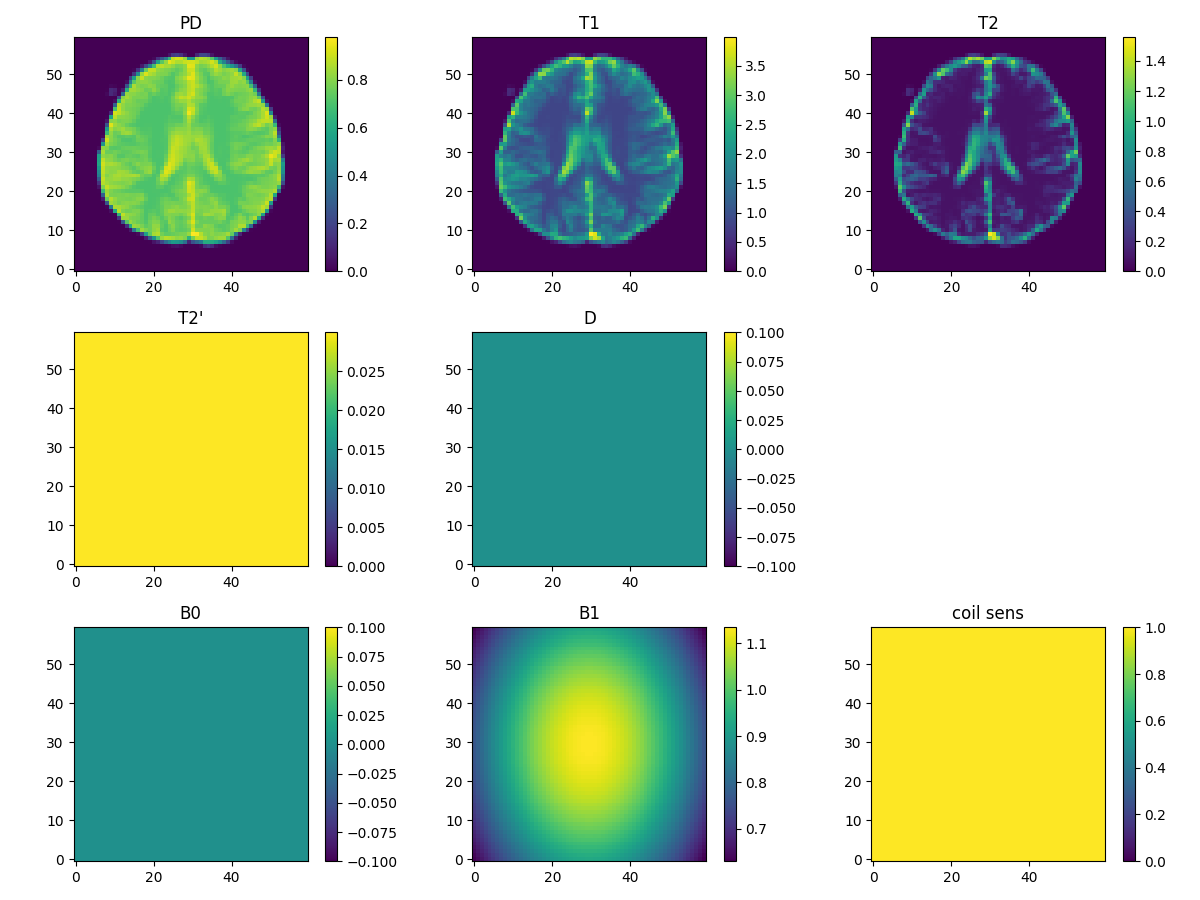

In [2]:
seq_path = os.path.join('out_seq', 'spiral_3D_linear_stack_trueFISP_linear45.0_nTR128_neco2_Tread3.00_TR10.96ms_FA12.seq')
seqp = pp.Sequence()
seqp.read(seq_path)
print('Sequence signature: ' + seqp.signature_value)
traj_name = seqp.signature_value
# Load the metadata
traj = loadmat("out_trajectory/" + traj_name)

n_unique_angles = traj['param']['interleaves'][0,0][0,0]

kx = traj['kx'][:,:]
ky = traj['ky'][:,:]
kz = traj['kz'][:,:]
pre_discard = traj['param']['pre_discard'][0,0][0,0]

Nkz = int(traj['param']['matrix_size'][0,0][0,2])
Nread = kx.shape[0]
Nphase = n_unique_angles
n_eco = int(np.max(traj['param']['contrast'][0,0][0,:])+1)

ktraj = np.stack((kx, -ky), axis=2)

# find max ktraj value
kmax = np.max(np.abs(kx + 1j * ky))

# swap 0 and 1 axes to make repetitions the first axis (repetitions, interleaves, 2)
ktraj = np.swapaxes(ktraj, 0, 1)

msize = np.int16(10 * traj['param']['fov'][0,0][0,0] / traj['param']['spatial_resolution'][0,0][0,0])

ktraj = 0.5 * (ktraj / kmax) * msize

w = traj['w']
w = np.reshape(w, (1,w.shape[1]))

# WARNING: Will load a lot of volunteer data
# 3D Brain Phantom from BrainWeb. 
# Run this once to save the phantom in a np file
if os.path.exists('brainweb/'):
    print("Volunteer data exists")
else:
    os.mkdir('brainweb')
    mr0.generate_brainweb_phantoms("brainweb", "3T")

sz = [int(traj['param']['matrix_size'][0,0][0,0]), int(traj['param']['matrix_size'][0,0][0,1]), int(traj['param']['matrix_size'][0,0][0,2])]    # spin system size / resolution
# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above

# (i) load a phantom object from file
phantom_fn = 'brainweb/subject04_3T.npz'
obj_p = mr0.VoxelGridPhantom.brainweb(phantom_fn)
obj_p = obj_p.interpolate(sz[0], sz[1], sz[2])
# Manipulate loaded data
obj_p.T2dash[:] = 30e-3
obj_p.D *= 0
obj_p.B0 *= 0

obj_p.plot()
# Convert Phantom into simulation data
obj_p = obj_p.build()

In [3]:
gpu_device = 2

seq0 = mr0.Sequence.import_file(seq_path)

# seq0.plot_kspace_trajectory()
kspace_loc = seq0.get_kspace()
# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
with torch.cuda.device(gpu_device):
    signal = mr0.execute_graph(graph, seq0.cuda(), obj_p.cuda(), print_progress=True).cpu()


>>>> Rust - compute_graph(...) >>>
Converting Python -> Rust: 0.002348648 s
Compute Graph
Computing Graph: 6.389115 s
Analyze Graph
Analyzing Graph: 0.028759385 s
Converting Rust -> Python: 0.35817608 s
<<<< Rust <<<<
Calculating repetition 158 / 158 - done


In [4]:

# PLOT sequence with signal in the ADC subplot
# sp_adc, t_adc = mr0.util.pulseq_plot(seqp, clear=True, signal=signal.numpy())

kspace_adc = torch.reshape((signal), (-1, Nread + pre_discard)).clone().t()
kspace_loc = torch.reshape(kspace_loc, (-1, Nread + pre_discard, 4)).clone()
kspace_step_1 = traj['param']['kspace_step_1'][0,0].T
kspace_step_2 = traj['param']['kspace_step_2'][0,0].T
contrast = traj['param']['contrast'][0,0].T
nTR = kspace_step_1.shape[0]
kspace_rsp = np.zeros((Nkz, Nphase, n_eco, Nread+pre_discard), dtype=np.complex64)
kspaceloc_rsp = np.zeros((Nkz, Nphase, n_eco, Nread+pre_discard, 3), dtype=np.float32)
for ii in range(nTR):
    kspace_rsp[kspace_step_2[ii,0], kspace_step_1[ii,0], contrast[ii,0], :] = kspace_adc[:, ii].numpy()
    kspaceloc_rsp[kspace_step_2[ii,0], kspace_step_1[ii,0], contrast[ii,0], :  ,:] = kspace_loc[ii, :, :3].numpy()


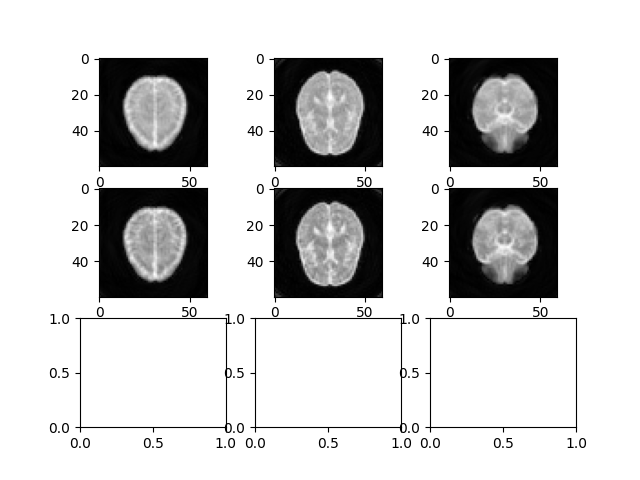

In [8]:
import sigpy as sp
from sigpy import fourier

ksp_slc = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(kspace_rsp, axes=(0)), axis=0), axes=0)
# ksp_slc = np.array(kspace_adc)
ksp_slc = ksp_slc.transpose(2, 0, 3, 1)[:,:,pre_discard:,:]
nchannel = 1
# Reconstruct
device = sp.Device(gpu_device)

ktraj_disc = ktraj[:Nphase,:,:].transpose(1, 0, 2)

coord_gpu = sp.to_device(ktraj_disc, device=device)
adata = sp.to_device(ksp_slc, device=device)

w_gpu = sp.to_device(w[None,:,:,None], device=device)
images = fourier.nufft_adjoint(adata*w_gpu,
                        coord_gpu,
                        (n_eco, Nkz, msize, msize))


# image = np.sum([sp.to_device(frame) for frame in frames], axis=0).squeeze()
images = sp.to_device(images)
f, axs = plt.subplots(3,3)
axs[0, 0].imshow(np.abs(images[0,10,:,:]).T, cmap='gray')
axs[0, 1].imshow(np.abs(images[0, 6,:,:]).T, cmap='gray')
axs[0, 2].imshow(np.abs(images[0, 2,:,:]).T, cmap='gray')
axs[1, 0].imshow(np.abs(images[1,10,:,:]).T, cmap='gray')
axs[1, 1].imshow(np.abs(images[1, 6,:,:]).T, cmap='gray')
axs[1, 2].imshow(np.abs(images[1, 2,:,:]).T, cmap='gray')